# Granger Causality
* Reference:
    * http://web.vu.lt/mif/a.buteikis/wp-content/uploads/2018/04/TasksP_07.html
    * https://www.statisticshowto.datasciencecentral.com/granger-causality/
    * To use Granger Casuality approach to show how sentiments affect the stock prices: https://www.kaggle.com/shrivastava/granger-casuality-tests-for-offsets

In [1]:
import numpy as np
import scipy
import pandas as pd

import statsmodels.api as sm
import statsmodels.stats as sm_stat
import statsmodels.tsa as smt
import statsmodels.graphics as smg
import statsmodels.tsa as tsa
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

params = {'legend.fontsize': 'x-large',
      'figure.figsize': (12, 8),
      'axes.labelsize': 'x-large',
      'axes.titlesize': 'x-large',
      'xtick.labelsize': 'x-large',
      'ytick.labelsize': 'x-large'}
plt.rcParams.update(params)
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Example 1: Synthetic Time Series
* Consider the following two processes:
$$
\begin{cases}
X_t = 0.2 X_{t-1} + w_{t},\ w_t \sim \mathcal{N}(0,1) \\
Y_t = 0.3 Y_{t-1} - 0.5 Y_{t-2} + 0.2 Y_{t-3} - 0.2 X_{t-1} - 0.3 X_{t-2} - 0.1 X_{t-3} + \varepsilon_t,\ \varepsilon_t \sim \mathcal{N}(0,1)
\end{cases}
$$

In [2]:
np.random.seed(1)

N = 500

X = np.zeros(N)
Y = np.zeros(N)

w = np.random.normal(loc = 0.0, scale = 1.0, size = N) 
e = np.random.normal(loc = 0.0, scale = 1.0, size = N) 

In [3]:
X[0] = w[0]
for j in range(1, N):
    X[j] = 0.2 * X[j - 1] + w[j]

In [4]:
Y[0] = e[0]
Y[1] = 0.3 * Y[0] - 0.2 * X[0] + e[1]
Y[2] = 0.3 * Y[1] - 0.5 * Y[0] - 0.2 * X[1] - 0.3 * X[0] + e[2]
for j in range(3, N):
    Y[j] = 0.3 * Y[j - 1] - 0.5 * Y[j - 2] + 0.2 * Y[j - 3] - 0.2 * X[j - 1] - 0.3 * X[j - 2] - 0.1 * X[j - 3] + e[j]

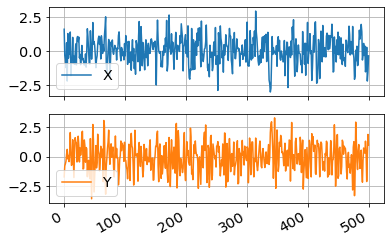

In [5]:
DT = pd.DataFrame([X, Y], index = ["X", "Y"]).T
DT.plot(subplots = True, layout = (2, 1), grid = True)
plt.show()

In [6]:
smt.stattools.arma_order_select_ic(DT["X"].values)

{'bic':              0            1            2
 0  1435.946725  1426.259458  1431.405857
 1  1425.628073  1431.827017  1433.150842
 2  1431.816874  1434.502139  1442.833460
 3  1436.367230  1439.343880  1443.400624
 4  1442.059402  1445.503445  1448.162016, 'bic_min_order': (1, 0)}

In [7]:
smt.stattools.arma_order_select_ic(DT["Y"].values)

{'bic':              0            1            2
 0  1655.590151  1584.440470  1547.564534
 1  1644.332854  1575.149921  1546.392505
 2  1524.057817  1514.637941  1514.083175
 3  1511.461985  1517.657670  1519.986364
 4  1517.642161  1523.133627  1525.807653, 'bic_min_order': (3, 0)}

### Digression: Building Tools

In [8]:
# Lag operator:
def L(x, n = 1):
    if n == 0:
        return x
    if isinstance(x, pd.Series):
        return x.shift(n) 
    else:
        x = pd.Series(x)
        return x.shift(n)

# Difference operator:
def d(x):
    if isinstance(x, pd.Series):
        return x.diff() 
    else:
        x = pd.Series(x)
        return x.diff() 

# Trend/time operator:
def time(x):
    return list(range(1, len(x) + 1))

In [9]:
def get_coef(mdl_fit):
    result = np.round(pd.DataFrame([mdl_fit.params, mdl_fit.tvalues, mdl_fit.pvalues], index = ["coef", "t-value", "p-value"]).T, 5)
    return(result)

### Step 1: The Unrestricted Model
* Consider the following model: $$Y_t = \alpha + \delta t + \phi_1 Y_{t-1} + ... + \phi_p Y_{t-p} + \beta_1 X_{t-1} + ... + \beta_q X_{t-q} + \epsilon_t.$$

In [10]:
mod_UR = smf.ols(formula = "Y ~ 1 + time(Y) + L(Y, 1) + L(Y, 2) + L(Y, 3) + L(Y, 4) + L(X, 1) + L(X, 2) + L(X, 3) + L(X, 4)", data = DT).fit()
get_coef(mod_UR)

,coef,t-value,p-value
Intercept,0.04786,0.54051,0.58909
time(Y),-0.00010,-0.31712,0.75129
"L(Y, 1)",0.26118,5.81055,0.00000
"L(Y, 2)",-0.46762,-10.35969,0.00000
"L(Y, 3)",0.16800,3.82247,0.00015
"L(Y, 4)",0.03509,0.84809,0.39680
"L(X, 1)",-0.15171,-3.43602,0.00064
"L(X, 2)",-0.35091,-7.72272,0.00000
"L(X, 3)",-0.15685,-3.25712,0.00120
"L(X, 4)",0.14562,3.00051,0.00283


In [11]:
print("Series means are:\n", DT.mean(axis = 0))
print("Series variances are:\n", DT.var(axis = 0))

Series means are:
 X    0.066959
Y   -0.016831
dtype: float64
Series variances are:
 X    1.011222
Y    1.569013
dtype: float64


In [12]:
mod_UR = smf.ols(formula = 'Y ~ -1 + L(Y, 1) + L(Y, 2) + L(Y, 3) + L(X, 1) + L(X, 2) + L(X, 3) + L(X, 4)', data = DT).fit()
get_coef(mod_UR)

,coef,t-value,p-value
"L(Y, 1)",0.26850,6.07557,0.00000
"L(Y, 2)",-0.48680,-12.57832,0.00000
"L(Y, 3)",0.18030,4.34041,0.00002
"L(X, 1)",-0.14919,-3.39262,0.00075
"L(X, 2)",-0.34744,-7.68324,0.00000
"L(X, 3)",-0.15513,-3.23323,0.00131
"L(X, 4)",0.14259,2.97370,0.00309


### Step 2: The Restricted Model
* Consider the following model:
$$Y_t = \alpha + \delta t + \phi_1 Y_{t-1} + ... + \phi_p Y_{t-p} + \epsilon_t.$$

In [13]:
mod_R = smf.ols(formula = 'Y ~ -1 + L(Y, 1) + L(Y, 2) + L(Y, 3)', data = DT).fit()
get_coef(mod_R)

,coef,t-value,p-value
"L(Y, 1)",0.36183,8.20549,0.00000
"L(Y, 2)",-0.52855,-12.97914,0.00000
"L(Y, 3)",0.19286,4.37158,0.00002


### Step 3: Model Comparison

In [14]:
sm_stat.api.anova_lm(mod_R, mod_UR)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,494.0,561.093262,0.0,NaN,NaN,NaN
1,489.0,457.810248,5.0,103.283014,22.063898,5.886248e-20


In [15]:
pd.DataFrame([mod_R.ssr, mod_UR.ssr], index = ["Restricted", "Unrestricted"], columns = ["SSR"]).T

,Restricted,Unrestricted
SSR,561.093262,457.810248


In [16]:
pd.DataFrame([mod_R.aic, mod_UR.aic], index = ["Restricted", "Unrestricted"], columns = ["AIC"]).T

,Restricted,Unrestricted
AIC,1476.709564,1381.846942


In [17]:
pd.DataFrame([mod_R.bic, mod_UR.bic], index = ["Restricted", "Unrestricted"], columns = ["BIC"]).T

,Restricted,Unrestricted
BIC,1489.335334,1411.292974


* So we conclude that $X$ Granger causes $Y$.

### Step 4: The Opposite Direction

In [18]:
X_UR = smf.ols(formula = 'X ~ -1 + L(Y, 1) + L(X, 1)', data = DT).fit()
get_coef(X_UR)

,coef,t-value,p-value
"L(Y, 1)",0.03078,0.87004,0.38470
"L(X, 1)",0.18394,4.18541,0.00003


In [19]:
X_R = smf.ols(formula = 'X ~ -1 + L(X, 1)', data = DT).fit()
get_coef(X_R)

,coef,t-value,p-value
"L(X, 1)",0.18357,4.1781,0.00003


In [20]:
sm_stat.api.anova_lm(X_R, X_UR)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,498.0,487.12786,0.0,NaN,NaN,NaN
1,497.0,486.38705,1.0,0.74081,0.756974,0.384697


In [21]:
pd.DataFrame([X_R.ssr, X_UR.ssr], index = ["Restricted", "Unrestricted"], columns = ["SSR"]).T

,Restricted,Unrestricted
SSR,487.12786,486.38705


In [22]:
pd.DataFrame([X_R.aic, X_UR.aic], index = ["Restricted", "Unrestricted"], columns = ["AIC"]).T

,Restricted,Unrestricted
AIC,1406.085005,1407.325562


In [23]:
pd.DataFrame([X_R.bic, X_UR.bic], index = ["Restricted", "Unrestricted"], columns = ["BIC"]).T

,Restricted,Unrestricted
BIC,1410.297611,1415.750775


* We can conclude that Y does not Granger cause X.

### How to use API?
- https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.grangercausalitytests.html

In [24]:
from statsmodels.tsa.stattools import grangercausalitytests

granger_test_result = grangercausalitytests(DT.values[:, [1, 0]], maxlag = 2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.8316 , p=0.0000  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=19.9515 , p=0.0000  , df=1
likelihood ratio test: chi2=19.5630 , p=0.0000  , df=1
parameter F test:         F=19.8316 , p=0.0000  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=45.3654 , p=0.0000  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=91.6510 , p=0.0000  , df=2
likelihood ratio test: chi2=84.1275 , p=0.0000  , df=2
parameter F test:         F=45.3654 , p=0.0000  , df_denom=493, df_num=2


In [25]:
granger_test_result = grangercausalitytests(DT.values, maxlag = 2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7873  , p=0.3754  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.7920  , p=0.3735  , df=1
likelihood ratio test: chi2=0.7914  , p=0.3737  , df=1
parameter F test:         F=0.7873  , p=0.3754  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4783  , p=0.6201  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=0.9663  , p=0.6168  , df=2
likelihood ratio test: chi2=0.9654  , p=0.6171  , df=2
parameter F test:         F=0.4783  , p=0.6201  , df_denom=493, df_num=2


## Example 2: TWII and TWDUSD

In [26]:
%%capture

!pip install yfinance

import yfinance as yf

In [27]:
tbl = pd.DataFrame(yf.download("^twii, usdtwd=x", period = "10y")["Adj Close"]).dropna()
tbl.columns = [x.lower() for x in tbl.columns]
tbl

[*********************100%***********************]  2 of 2 completed


,usdtwd=x,^twii
Date,,
2011-07-04,28.745001,8774.687500
2011-07-05,28.660000,8784.408203
2011-07-06,28.750000,8824.408203
2011-07-07,28.825001,8773.387695
2011-07-08,28.809999,8749.517578
...,...,...
2021-06-28,27.865801,17590.970703
2021-06-29,27.816000,17598.189453
2021-06-30,27.875900,17755.460938


In [29]:
granger_test_result = grangercausalitytests(tbl.values, maxlag = 3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0258  , p=0.8724  , df_denom=2416, df_num=1
ssr based chi2 test:   chi2=0.0258  , p=0.8724  , df=1
likelihood ratio test: chi2=0.0258  , p=0.8724  , df=1
parameter F test:         F=0.0258  , p=0.8724  , df_denom=2416, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3684  , p=0.0346  , df_denom=2413, df_num=2
ssr based chi2 test:   chi2=6.7508  , p=0.0342  , df=2
likelihood ratio test: chi2=6.7414  , p=0.0344  , df=2
parameter F test:         F=3.3684  , p=0.0346  , df_denom=2413, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3572  , p=0.0699  , df_denom=2410, df_num=3
ssr based chi2 test:   chi2=7.0921  , p=0.0690  , df=3
likelihood ratio test: chi2=7.0817  , p=0.0693  , df=3
parameter F test:         F=2.3572  , p=0.0699  , df_denom=2410, df_num=3


In [30]:
granger_test_result = grangercausalitytests(tbl.values[:, [1, 0]], maxlag = 3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6473  , p=0.4211  , df_denom=2416, df_num=1
ssr based chi2 test:   chi2=0.6481  , p=0.4208  , df=1
likelihood ratio test: chi2=0.6480  , p=0.4208  , df=1
parameter F test:         F=0.6473  , p=0.4211  , df_denom=2416, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6689  , p=0.5124  , df_denom=2413, df_num=2
ssr based chi2 test:   chi2=1.3406  , p=0.5115  , df=2
likelihood ratio test: chi2=1.3402  , p=0.5116  , df=2
parameter F test:         F=0.6689  , p=0.5124  , df_denom=2413, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4951  , p=0.6857  , df_denom=2410, df_num=3
ssr based chi2 test:   chi2=1.4895  , p=0.6847  , df=3
likelihood ratio test: chi2=1.4890  , p=0.6848  , df=3
parameter F test:         F=0.4951  , p=0.6857  , df_denom=2410, df_num=3
